<a href="https://colab.research.google.com/github/SanjanaTikare117/Kaggle-Deep-Learning-Regression-with-Mohrs-Hardness/blob/main/Regression_with_Mohrs_Hardness_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor




In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks
import tensorflow_probability as tfp



In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [ ]:
train.describe()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.00000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,5203.00000,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,3004.38646,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2601.50000,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,5203.00000,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,7804.50000,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,10406.00000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


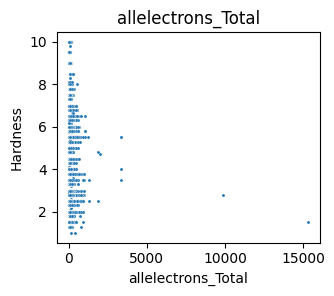

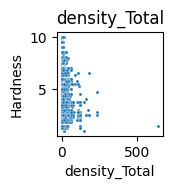

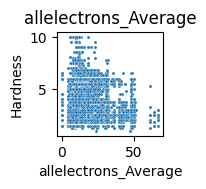

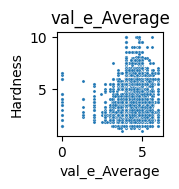

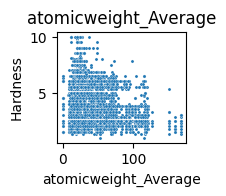

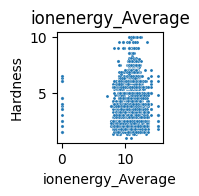

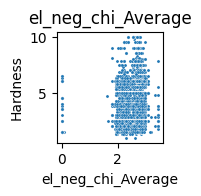

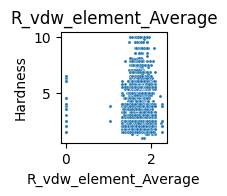

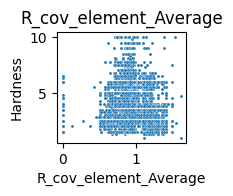

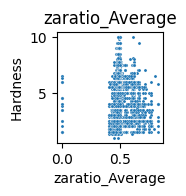

In [ ]:
fig = plt.figure(figsize = (12,8))
i = 1
for label in train.drop(columns=['id']).columns[:-2]:
  plt.subplot(3, 4, i)
  sns.scatterplot(train,x= label, y="Hardness", s=5)
  plt.title(label)
  i+=1
  plt.tight_layout()
  plt.show()

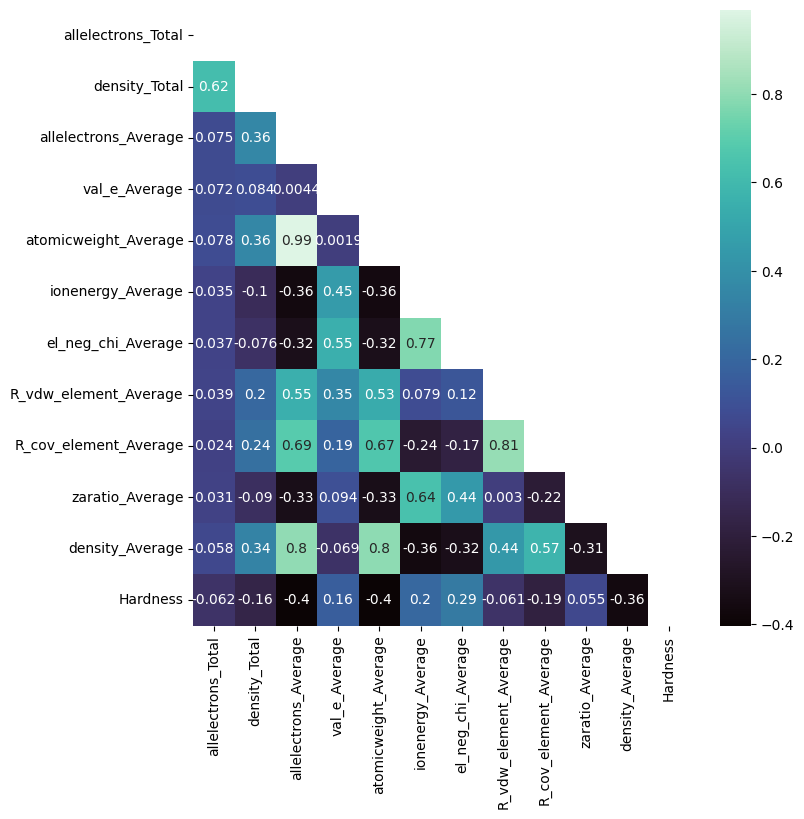

In [ ]:
plt.figure(figsize=(8,8))
corr=train.drop(columns=['id']).corr()
sns.heatmap(corr,annot=True,cmap='mako',mask=np.triu(corr))
plt.show()

In [ ]:
def add_features(df):
    df['n_elements']=df['allelectrons_Total']/(df['allelectrons_Average']+1e-5)
    df['total_weight']=df['n_elements']*df['atomicweight_Average']
    return df

train = add_features(train)

In [ ]:
features = [column for column in train.columns if column != 'Hardness'] # get list of features excluding 'Hardness'
target = 'Hardness'


print(features)
print(target)

['id', 'allelectrons_Total', 'density_Total', 'allelectrons_Average', 'val_e_Average', 'atomicweight_Average', 'ionenergy_Average', 'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average', 'zaratio_Average', 'density_Average', 'n_elements', 'total_weight']
Hardness


In [ ]:
X = train[features]
y = train[target]

In [ ]:
def mae_loss(y_true, y_pred):
    '''
    Custom loss function for this competition.
    input: y_true (true values), y_pred (predicted values)
    output: loss value, calculated as the 50th percentile (median) of the absolute difference between y_true and y_pred
    '''
    return tfp.stats.percentile(tf.abs(y_true - y_pred), 50.0)


In [ ]:
def metricfunction (y_true, y_pred):
    '''
    Custom metric function for this competition.
    input: y_true (true values), y_pred (predicted values)
    output: metric value, calculated as the 100th percentile (maximum) of the absolute difference between y_true and y_pred minus the 0th percentile (minimum) of the absolute difference between y_true and y_pred
    '''
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=100) - tfp.stats.percentile(tf.abs(y_true - y_pred),q=0)

In [ ]:
def create_model(optimizer):


    input_layer = tf.keras.Input(shape=(len(features),))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation ='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    # Model instantiation
    model = tf.keras.Model(inputs = input_layer, outputs = output_layer)
    model.compile(optimizer=optimizer, loss = mae_loss)

    return model

# Define callbacks to use for quick training
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
optimizer_list = [
    tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    tf.keras.optimizers.RMSprop(learning_rate=0.001),
    tf.keras.optimizers.Adam(learning_rate=0.01), #Baseline from other notebooks
    tf.keras.optimizers.Adagrad(learning_rate=0.01),
]

In [ ]:

    # Train models with different optimizers and select the best one
    best_score = float('inf')
    best_optimizer = None

    for optimizer in optimizer_list:
        model = create_model(optimizer)
        history = model.fit(X, y, callbacks=callbacks, epochs=100, validation_split=0.2, verbose=0)

        # Evaluate model, e.g., using validation loss
        val_loss = min(history.history['val_loss'])
        print(f'{optimizer.get_config()["name"]} loss: {val_loss}')
        if val_loss < best_score:
            best_score = val_loss
            best_optimizer = optimizer

    print(f'\n\nBest optimizer: {best_optimizer.get_config()["name"]}')

SGD loss: 0.6798046231269836
RMSprop loss: 0.6693850755691528
Adam loss: 0.6657077074050903
Adagrad loss: 0.7549641728401184


Best optimizer: Adam


In [ ]:

    # Define hyperparameter grid for the model
    epsilons = [1.5e-4, 1e-5, 1.5e-5] #epsilon is a small constant added to prevent division by zero in the update steps.

    # Update early stopping contitions to be more tolerant of plateauing (patience=30)
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.8, patience=3, min_lr=0.00001),
        tf.keras.callbacks.TerminateOnNaN()
    ]

    best_score = float('inf')
    best_params = None
    best_model = None

    # Train models with different hyperparameters and select the best one
    for epsilon in epsilons:
        print(f"Training with epsilon={epsilon}")
        optimizer = tf.keras.optimizers.Adam(epsilon=epsilon)
        model = create_model(optimizer)
        history = model.fit(X, y, callbacks=callbacks, epochs=150, validation_split=0.2, verbose=0)

        val_loss = min(history.history['val_loss'])
        if val_loss < best_score:
            best_score = val_loss
            best_params = {'epsilon': epsilon}
            best_model = model  # save the best model

    print(f"Best parameters: {best_params}")

    print(f'\n\nBest parameters: {best_params}')

Training with epsilon=0.00015
Training with epsilon=1e-05
Training with epsilon=1.5e-05
Best parameters: {'epsilon': 1e-05}


Best parameters: {'epsilon': 1e-05}


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.5, beta_2=0.999, epsilon=1e-05)
model = create_model(optimizer)
history = model.fit(X, y, callbacks=callbacks, epochs=200, validation_split=0.2, verbose=0)

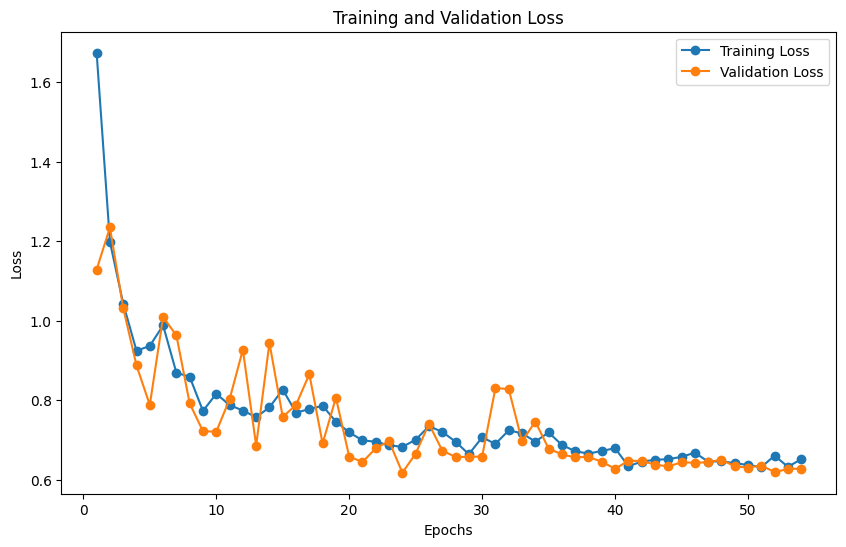

In [ ]:
# Extract loss data
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Extract number of epochs
epochs = range(1, len(training_loss) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'o-', label='Training Loss')
plt.plot(epochs, validation_loss, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
test = pd.read_csv('/content/test.csv')
test = add_features(test)
X_submission = test[features]

In [ ]:
preds = []
preds = model.predict(X_submission)
preds = pd.DataFrame(preds, columns=['target'])

217/217 [==============================] - 0s 2ms/step
